In [67]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

from skimage.io import imread, imshow
from sklearn.metrics import  f1_score, precision_score, recall_score, jaccard_score

### Metrics

In [68]:
def dice_coef(y_true, y_pred, smooth=1):
    # Ensure the tensors are of type float32
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


### Data Preprocessing

In [38]:
# Params
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [39]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_WIDTH, IMG_HEIGHT), method="nearest")
    input_mask = tf.image.resize(input_mask, (IMG_WIDTH, IMG_HEIGHT), method="nearest")
    # Convert mask to grayscale
    input_mask = tf.image.rgb_to_grayscale(input_mask)

    return input_image, input_mask 

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
  
    return input_image, input_mask

In [40]:
X_train = []
Y_train = []
X_test = []

# Conta a quantidade de imagens de test
n_test = len(os.listdir(TEST_PATH+'images'))
n_train = len(os.listdir(TRAIN_PATH+'images'))


X_train = np.zeros((n_train, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((n_train, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
X_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print(X_train.shape)

# Load test images
for i in tqdm(range(n_test)):
    img = imread(TEST_PATH+'images/'+os.listdir(TEST_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.image.flip_left_right(img)
    X_test[i] = img

# Load train images
for i in tqdm(range(n_train)):
    img = imread(TRAIN_PATH+'images/'+os.listdir(TRAIN_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(TRAIN_PATH+'labels/'+os.listdir(TRAIN_PATH+'labels')[i])
    img, mask = resize(img, mask)
    img, mask = augment(img, mask)
    X_train[i] = img
    Y_train[i] = mask
    

(810, 128, 128, 3)


100%|██████████| 810/810 [00:14<00:00, 55.33it/s]


### Model - Unet Modificada


In [41]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    return x

In [42]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p

In [43]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [44]:
def build_unet_model():
    # Input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalizing the inputs

    initial_filters = 16

    # Encoder
    c1, p1 = downsample_block(s, initial_filters)
    c2, p2 = downsample_block(p1, initial_filters*2)
    c3, p3 = downsample_block(p2, initial_filters*4)
    c4, p4 = downsample_block(p3, initial_filters*8)

    # Bottleneck
    bn = double_conv_block(p4, initial_filters*16)

    # Decoder
    u6 = upsample_block(bn, c4, initial_filters*8)
    u7 = upsample_block(u6, c3, initial_filters*4)
    u8 = upsample_block(u7, c2, initial_filters*2)
    u9 = upsample_block(u8, c1, initial_filters)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(u9)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [122]:
model = build_unet_model()
# Params
BATCH_SIZE=16
EPOCHS=100

# model.summary()
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.CategoricalAccuracy()])
model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-4), loss=bce_dice_loss, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)])

### Fitting


In [123]:
# training date - take the today's date
import datetime
today = datetime.date.today()
today = today.strftime("%Y-%m-%d")

#Checkpoint
file_path = "models/" + today + "_model.keras"
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_best_only=True, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0213 - loss: 1.0199 - mean_io_u_6: 0.4935
Epoch 1: val_loss improved from inf to 0.80086, saving model to models/2024-09-23_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - dice_coef: 0.0210 - loss: 1.0139 - mean_io_u_6: 0.4935 - val_dice_coef: 0.0162 - val_loss: 0.8009 - val_mean_io_u_6: 0.4930
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0065 - loss: 0.6461 - mean_io_u_6: 0.4938
Epoch 2: val_loss improved from 0.80086 to 0.69740, saving model to models/2024-09-23_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - dice_coef: 0.0066 - loss: 0.6452 - mean_io_u_6: 0.4938 - val_dice_coef: 0.0299 - val_loss: 0.6974 - val_mean_io_u_6: 0.4930
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0342 - loss: 0.5574 - mean_io_u_6: 0.4937
Epoch 3: val_loss improved from 0.69740 to 0.62576, saving model to models/2024-09-23_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - dice_coef: 0.0350 

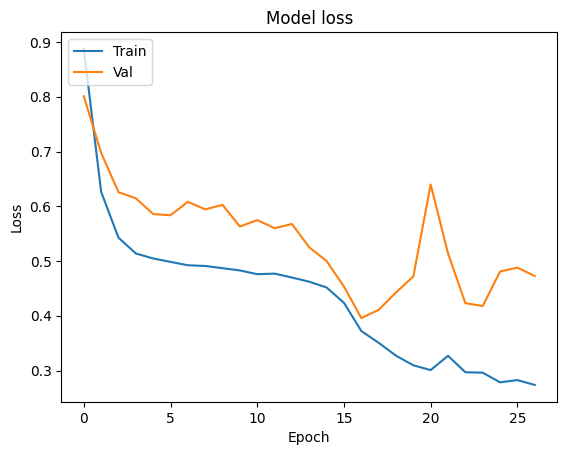

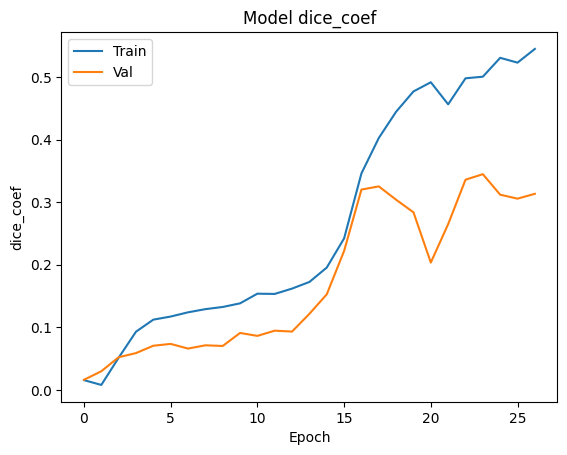

In [124]:
#Plot the training and validation loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# #Plot the training and validation mean_iou
# plt.plot(results.history['mean_io_u'])
# plt.plot(results.history['val_mean_io_u'])
# plt.title('Model mean_iou')
# plt.ylabel('mean_iou')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

# #Plot the training and validation precision
# plt.plot(results.history['precision'])
# plt.plot(results.history['val_precision'])
# plt.title('Model precision')
# plt.ylabel('precision')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

# #Plot the training and validation recall
# plt.plot(results.history['recall'])
# plt.plot(results.history['val_recall'])
# plt.title('Model recall')
# plt.ylabel('recall')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

# #Plot the training and validation categorical_accuracy
# plt.plot(results.history['categorical_accuracy'])
# plt.plot(results.history['val_categorical_accuracy'])
# plt.title('Model categorical_accuracy')
# plt.ylabel('categorical_accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

#Plot the training and validation dice_coef
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Predictions

In [5]:
#carrega o modelo
#model = tf.keras.models.load_model('models/2024-09-20_batch32_model.keras', safe_mode=False)

In [116]:
# Val data
VAL_PATH = 'data/validation/'

n_val = len(os.listdir(VAL_PATH+'images'))

X_val = np.zeros((n_val, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((n_val, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Load val images
for i in tqdm(range(n_val)):
    img = imread(VAL_PATH+'images/'+os.listdir(VAL_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(VAL_PATH+'labels/'+os.listdir(VAL_PATH+'labels')[i])
    img, mask = resize(img, mask)
    X_val[i] = img
    Y_val[i] = mask

100%|██████████| 200/200 [00:03<00:00, 51.03it/s]


In [117]:
# Predict on val, train and test
preds_val = model.predict(X_val, verbose=1)
# preds_train = model.predict(X_train, verbose=1)
# preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.3).astype(np.uint8)
# preds_train_t = (preds_train > 0.3).astype(np.uint8)
# preds_test_t = (preds_test > 0.3).astype(np.uint8)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step


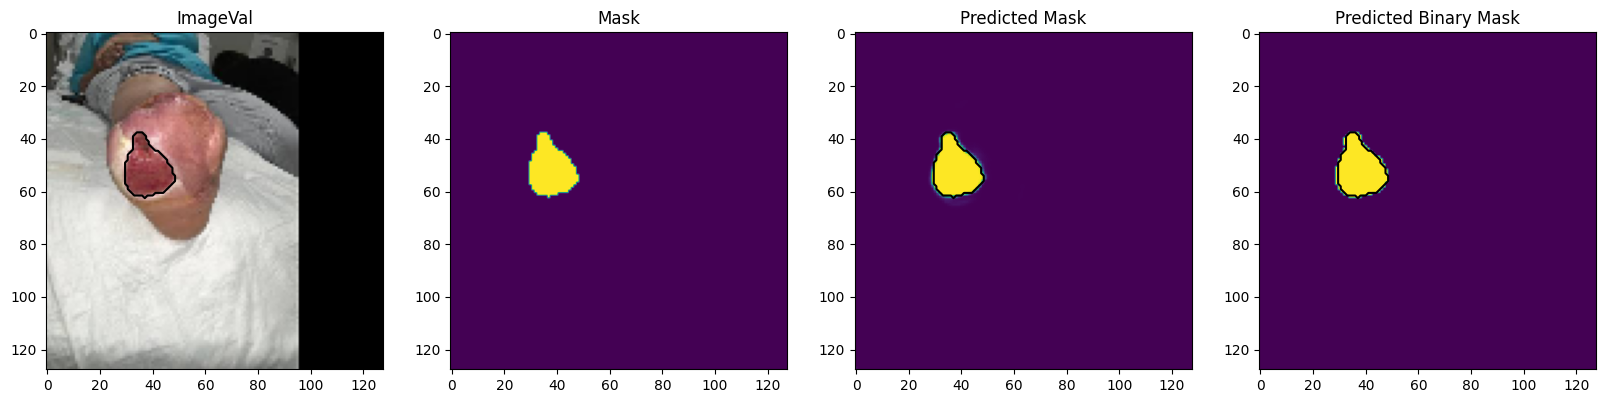

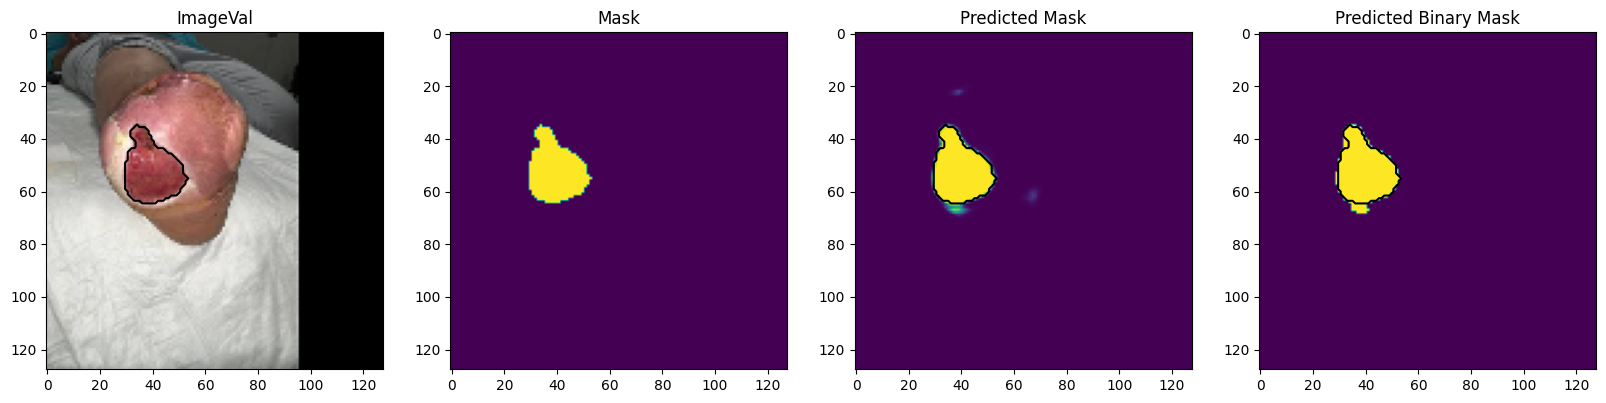

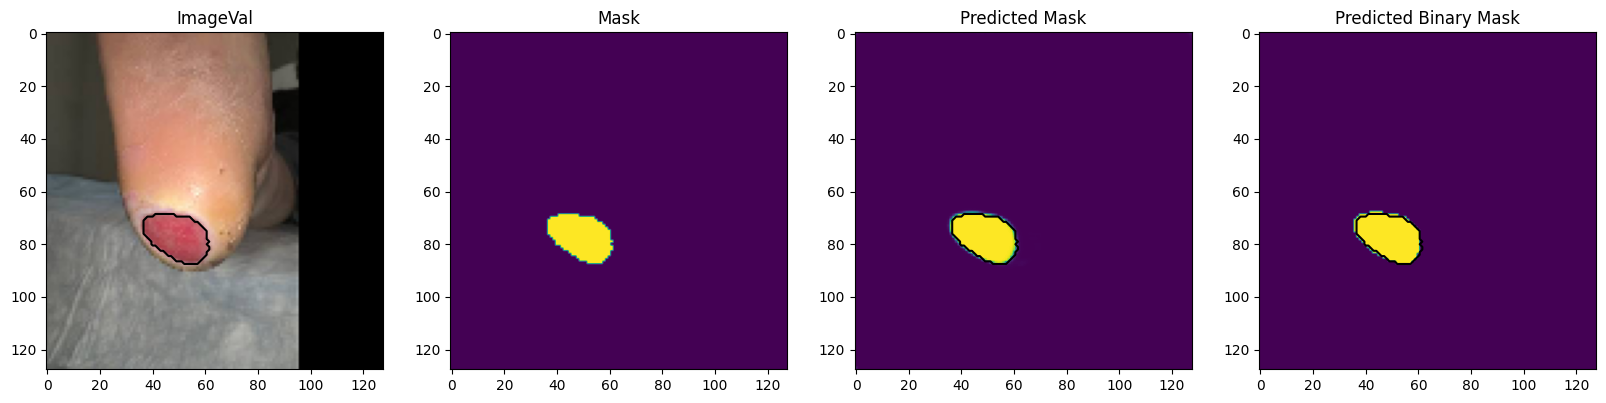

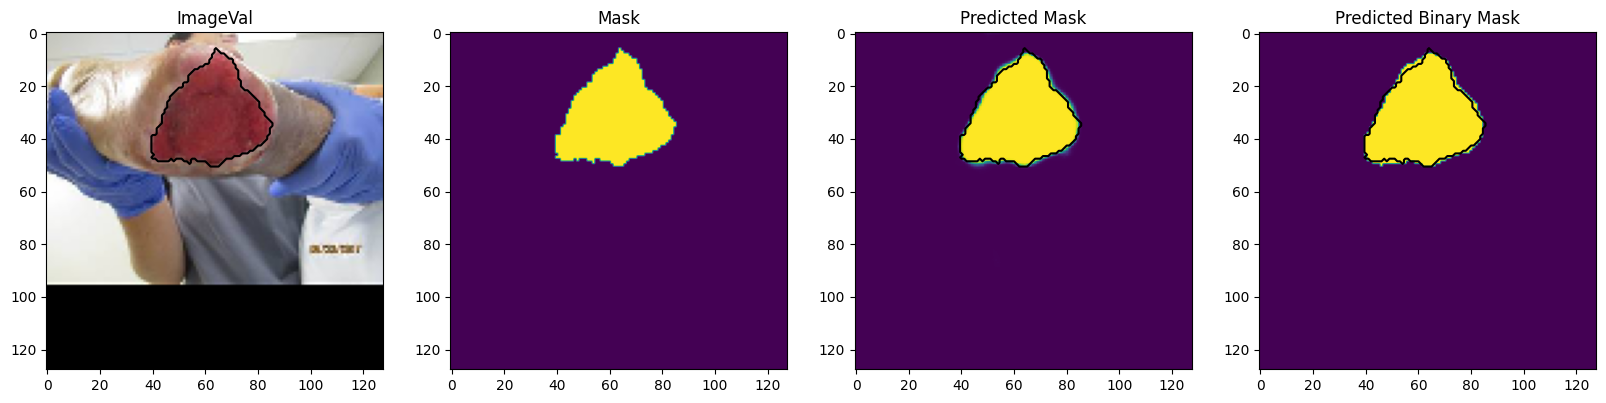

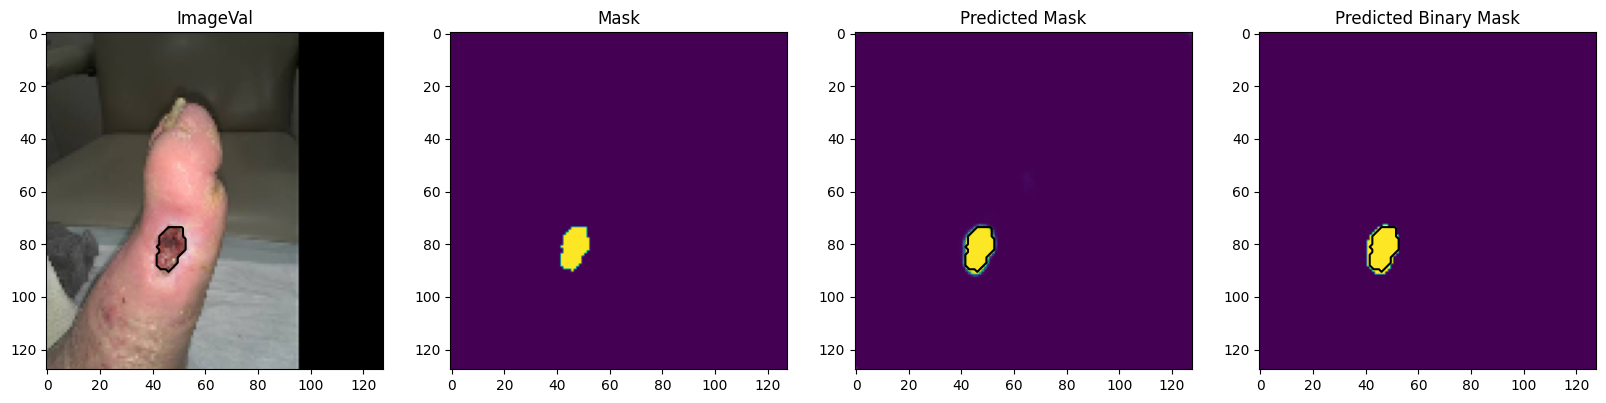

In [118]:
# Plot the results
def plot_sample(title, X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image' + title)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Binary Mask')

# Check if training data looks all right
# plot_sample("Train", X_train, Y_train, preds_train, preds_train_t)

# Check if valid data looks all right
plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=130)
plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=155)
plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=135)
plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=184)
plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=69)

# Check if test data looks all right
# Y_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# plot_sample("Test", X_test, Y_test, preds_test, preds_test_t)

## Evaluate

In [119]:
#115 é para acertar, e 30 é para errar
# Melhores [130, 0.985172981878089], [155, 0.9750271444082519], [135, 0.9725829725829725], [184, 0.9608150470219435], [69, 0.9565217391304348]
# Piores [[4, 0.0], [30, 0.0], [43, 0.0], [53, 0.0], [83, 0.0]]
# Medianos [[13, 0.5228519195612431], [67, 0.5454545454545454], [164, 0.5668449197860963], [65, 0.5703125], [183, 0.573208722741433]]
ix = 115

F1 score: 0.9230769230769231


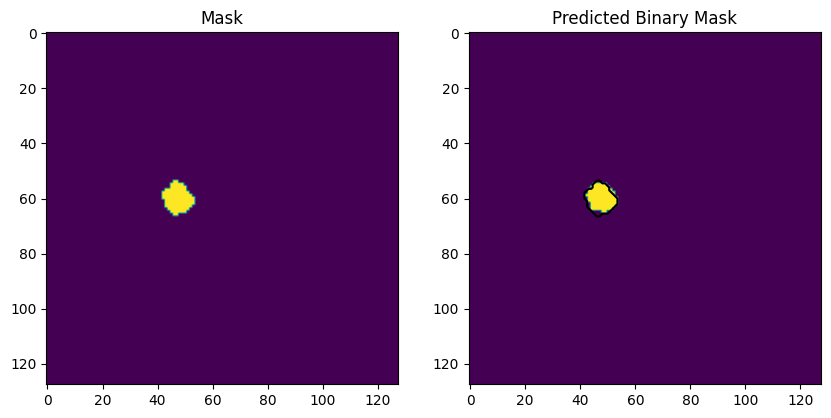

115


In [120]:

f1_value = f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten())
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(Y_val[ix].squeeze())
ax[1].imshow(preds_val_t[ix].squeeze())
ax[0].set_title('Mask')
ax[1].set_title('Predicted Binary Mask')
ax[1].contour(Y_val[ix].squeeze(), colors='k', levels=[0.5])
print("F1 score:", f1_value)
# Espera o usuário pressionar uma tecla para continuar
plt.show()
# ix= ix + 1
print(ix)

In [121]:
# Função que calcula o Dice Coefficient
# np.sum(mask1 * mask2) calcula o número de elementos em comum entre as duas máscaras mask1 e mask2. Como as máscaras são binárias (0 ou 1), a multiplicação de
# mask1 por mask2 resulta em 1 apenas onde ambos têm valor 1, e em 0 onde qualquer um tem valor 0. A soma (np.sum) desses produtos dá a quantidade de pixels que são 1 em
# ambas as máscaras, ou seja, a interseção entre elas.
# np.sum(mask1) e np.sum(mask2) calculam a quantidade de pixels que são 1 em cada uma das máscaras, ou seja, a soma de todos os pixels de cada máscara.
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    union = fsum + ssum
    if(union == 0):
        return 0
    dice = (2 * intersect ) / (union)
    return dice    

dice_values = []
for ix in range(len(X_val)):
    dice_values.append([ix, dice_coef(preds_val_t[ix].flatten(), Y_val[ix].flatten())])

jaccard_values = []
for ix in range(len(X_val)):
    jaccard_values.append([ix, jaccard_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])

f1_values = []
for ix in range(len(X_val)):
    f1_values.append([ix, f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])


recall_values = []
for ix in range(len(X_val)):
    recall_values.append([ix, recall_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])

precision_values = []
for ix in range(len(X_val)):
    precision_values.append([ix, precision_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])

print("Dice Score: ", np.mean(dice_values, axis=0)[1])
print("Jaccard/IoU Score: ", np.mean(jaccard_values, axis=0)[1])
print("F1 Score: ", np.mean(f1_values, axis=0)[1])
print("Recall Score: ", np.mean(recall_values, axis=0)[1])
print("Precision Score: ", np.mean(precision_values, axis=0)[1])


Dice Score:  0.5855596280214377
Jaccard/IoU Score:  0.4645745339797096
F1 Score:  0.5780386350868871
Recall Score:  0.8274510353734431
Precision Score:  0.5182757002923633


In [ ]:
# # Mostra o que teve os top 5 valores de F1
# f1_values.sort(key=lambda x: x[1], reverse=True)
# print(f1_values[:5])

# # Mostra o que teve os top 5 piores valores de F1
# f1_values.sort(key=lambda x: x[1], reverse=False)
# print(f1_values[:5])

# # Mostra os top 5 valores medianos de f1
# f1_values.sort(key=lambda x: x[1], reverse=False)
# print(f1_values[60:65])